# 1 Importar Librerias

In [16]:
#Librerias ETL
import pandas as pd
import numpy as np

#Librerias EDA
import seaborn as sns
import matplotlib.pyplot as plt


# 2 Leer CSV's

In [17]:
accAereosPrinc = 'AccidentesAviones.csv'
dfAccAereosPrinc = pd.read_csv(accAereosPrinc)
estadosUsa = 'UnitedStates.csv'
statesUsa = pd.read_csv(estadosUsa,delimiter = ';')

# 3 ETL (Extract, Trasnform and Load)

## 3.1 Renombrar indices

In [18]:
# ELIMINAR INDICE
#Columna a eliminar 
eliminIndice = 'Unnamed: 0'
if eliminIndice in dfAccAereosPrinc:
    dfAccAereosPrinc = dfAccAereosPrinc.drop(eliminIndice,axis= 1)
else: 
    print('Columna eliminada')

# Convertir fecha a datetime
dfAccAereosPrinc['fecha'] = pd.to_datetime(dfAccAereosPrinc['fecha'],format='%B %d, %Y')
# Extrarer la hora
dfAccAereosPrinc['Año'] = dfAccAereosPrinc['fecha'].dt.year
# Convertir HORA declara a datetime horas
#dfAccAereosPrinc['HORA declarada'] = pd.to_datetime(dfAccAereosPrinc['HORA declarada'], format = '%H%M', errors='coerce')

# Convertir a None , si teine ?
#def conveNulo (value):
#    return None if value == '?' else value
#dfAccAereosPrinc = dfAccAereosPrinc.applymap(conveNulo)

# Renombrar las columnas para un mejor entendimiento
cambioNombres = {'fecha': 'Fecha', 
                 'HORA declarada': 'Hora Declarada',
                 'OperadOR' : 'Operador',
                 'flight_no' : 'Numero de Vuelo',
                 'route' :'Destino y/o tipoVuelo',
                 'ac_type' : 'Tipo de aeronave',
                 'all_aboard' : 'Total Abordo',
                 'PASAJEROS A BORDO' : 'Pasajeros a bordo',
                 'crew_aboard' : 'Equipo a bordo',
                 'passenger_fatalities' : 'Pasajeros muertos',
                 'crew_fatalities': 'Equipo a bordo muertos' ,
                 'summary' : 'Resumen'   
                 }
dfAccAereosPrinc= dfAccAereosPrinc.rename(columns=cambioNombres)

## 3.2 Cambios Generales

In [19]:
# Eliminar duplicados que no sean desconocidos '?'
dfAccAereosPrinc = dfAccAereosPrinc[dfAccAereosPrinc['registration'] != '?'].drop_duplicates(subset = 'registration')

# Extraer el pais
dfAccAereosPrincPaises = dfAccAereosPrinc['Ruta'].str.split(',', expand=True)
cambioNombres = {0: 'Lugar', 
                 1: 'Pais o Estado',
                 2 : 'Pais o Estado 2',
                 3 : 'Pais o Estado 3',
                 }
columnasSinPunto = ['Lugar','Pais o Estado','Pais o Estado 2','Pais o Estado 3']
dfAccAereosPrincPaises= dfAccAereosPrincPaises.rename(columns=cambioNombres)

# Quitar el punto a los paises
dfAccAereosPrincPaises[columnasSinPunto] = dfAccAereosPrincPaises[columnasSinPunto].replace(['.'],'')


# Extraer de cada columans nueva creada el Pais Correspondiente
def nueva_columna(fila):
    if fila['Pais o Estado 3']  is not None:
        return fila['Pais o Estado 3']
    elif fila['Pais o Estado 2'] is not None:
        return fila['Pais o Estado 2']
    else:
        return fila['Pais o Estado']
dfAccAereosPrincPaises['Paises o Region'] = dfAccAereosPrincPaises.apply(nueva_columna, axis = 1)
# Quedarnos con las columas importantes 

dfAccAereosPrincPaises= dfAccAereosPrincPaises[['Lugar','Paises o Region']]
dfAccAereosPrincFinal = pd.merge(dfAccAereosPrinc, dfAccAereosPrincPaises, left_index=True, right_index=True)
dfAccAereosPrincFinal = dfAccAereosPrincFinal.drop('Ruta', axis=1)

#Importar tabla de estados , para saber si fue de USA o de otro pais

cambioName = {'State': 'Paises o Region' }
statesUsa= statesUsa.rename(columns=cambioName)
# Quitar espacios en blanco
statesUsa['Paises o Region'] = statesUsa['Paises o Region'].str.strip()
# Quitar .
dfAccAereosPrincFinal['Paises o Region'] = dfAccAereosPrincFinal['Paises o Region'].str.strip()


resultado = pd.merge(dfAccAereosPrincFinal, statesUsa, on='Paises o Region', how = 'left')
# Asignanar los valores finales a pais

def paisFinal(fila):
    if pd.notna(fila['Country']):
        return fila['Country']
    else:
        return fila['Paises o Region']
resultado['Pais'] = resultado.apply(paisFinal, axis = 1)
resultado= resultado.drop('Country', axis=1)

# Extraer si fue de noche o dia 
resultadoConteo = resultado['Hora Declarada'].str.count(':').sum()
resultado['Hora Declarada'] = resultado['Hora Declarada'].str.replace(':', '')
resultado
resultado['Hora Declarada'] = pd.to_datetime(resultado['Hora Declarada'], format='%H%M', errors = 'coerce')
# Etiquetado noche o dia
def periodoHora(hora):
    hora_inicio_dia = pd.to_datetime('06:00', format='%H:%M').time()
    hora_fin_dia = pd.to_datetime('18:00', format='%H:%M').time()
    if pd.isna(hora): 
        return 'Sin hora'
    elif hora_inicio_dia <= hora.time() < hora_fin_dia:
        return 'Dia'
    else:
        return 'Noche'
resultado['Tiempo'] = resultado['Hora Declarada'].apply(periodoHora)
# Eliminar columnas que no son necesarias 
resultado = resultado.drop('Hora Declarada', axis=1)
resultado

#Conversion de valores numeros
columnasAInt = ['Total Abordo','Pasajeros a bordo','Equipo a bordo','cantidad de fallecidos','Pasajeros muertos','Equipo a bordo muertos','ground']
def convertir_a_entero(valor):
    if valor == '?':
        return None
    else:
        try:
            return int(valor)
        except ValueError:
            return None # Establecer como NaN si no se puede convertir a int

resultado[columnasAInt] = resultado[columnasAInt].applymap(convertir_a_entero)
# Convertir a tipo de dato entero
resultado[columnasAInt] = resultado[columnasAInt].apply(pd.to_numeric, errors='coerce').astype(pd.Int64Dtype())

# RenombreGeneral a valor no determinado cuando corresponda
columnasANoDeter= ['Operador',
                'Numero de Vuelo',
                'Destino y/o tipoVuelo',
                'Tipo de aeronave', 
                'registration','cn_ln',
                'Resumen', 
                'Lugar',
                'Paises o Region',
                'Pais',
                'Tiempo',]
resultado[columnasANoDeter] = resultado[columnasANoDeter].replace(['?',None],'No determinado')
# Columnas a no Determinado
dfAccidentesLimpio =resultado

Dataframe Limpio 

In [20]:
dfAccidentesLimpio

,Fecha,Operador,Numero de Vuelo,Destino y/o tipoVuelo,Tipo de aeronave,registration,cn_ln,Total Abordo,Pasajeros a bordo,Equipo a bordo,cantidad de fallecidos,Pasajeros muertos,Equipo a bordo muertos,ground,Resumen,Año,Lugar,Paises o Region,Pais,Tiempo
0,1909-09-07,No determinado,No determinado,Air show,Wright Byplane,SC1,No determinado,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...,1909,Juvisy-sur-Orge,France,France,Sin hora
1,1917-06-17,No determinado,No determinado,No determinado,Zepplin L-48 (air ship),L-48,No determinado,16,<NA>,<NA>,14,<NA>,<NA>,0,Shot down by aircraft.,1917,Near Yarmouth,England,England,Sin hora
2,1918-12-16,US Aerial Mail Service,No determinado,No determinado,De Havilland DH-4,97,No determinado,1,0,1,1,0,1,0,Carl Smith was killed when his mail plane feet...,1918,Elizabeth,New Jersey,USA,Sin hora
3,1919-05-25,US Aerial Mail Service,No determinado,No determinado,De Havilland DH-4,61,No determinado,1,0,1,1,0,1,0,Caught fire in midair. The pilot leaped from t...,1919,Cleveland,Ohio,USA,Sin hora
4,1919-07-19,US Aerial Mail Service,No determinado,No determinado,De Havilland DH-4,82,No determinado,1,0,1,1,0,1,0,The mail plane crashed under unknown circumsta...,1919,Dix Run,Pennsylvania,USA,Sin hora
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4695,2021-03-28,Soloy Helicopters,No determinado,Sightseeing Charter,Eurocopter AS350B3 Ecureuil,N351SH,4598,6,5,1,5,4,1,0,The sightseeing helicopter crashed after missi...,2021,Near Butte,Alaska,USA,Noche
4696,2021-05-21,Military - Nigerian Air Force,No determinado,No determinado,Beechcraft B300 King Air 350i,NAF203,FL-891,11,7,4,11,7,4,0,"While on final approach, in poor weather condi...",2021,Near Kaduna,Nigeria,Nigeria,Noche
4697,2021-06-10,Military - Myanmar Air Force,No determinado,Naypyidaw - Anisakan,Beechcraft 1900D,4610,E-325,14,12,2,12,11,1,0,The plane was carrying military personnel and ...,2021,Near Pyin Oo Lwin,Myanmar,Myanmar,Dia
4698,2021-07-04,Military - Philippine Air Force,No determinado,Cagayan de Oro-Lumbia - Jolo,Lockheed C-130H Hercules,5125,5125,96,88,8,50,<NA>,<NA>,3,"While attempting to land at Jolo Airport, the ...",2021,Patikul,Philippines,Philippines,Dia


# 4 EDA (Exploratory Data Analysis)

## 4.1 Estadisticas descriptivas de los numeros de fallecidos

In [21]:
# Sacar nulos
muertesSinNulos = dfAccidentesLimpio['cantidad de fallecidos'].dropna()
cuartiles = np.percentile(muertesSinNulos, [25, 50, 75])
mediana = np.median(muertesSinNulos)
media = np.median(muertesSinNulos)
desviacion_estandar = np.std(muertesSinNulos)
print("Cuartiles:")
print("Q1 (25%):", cuartiles[0])
print("Mediana (50%):", mediana)
print("Q3 (75%):", cuartiles[2])
print("Media:", media)
print("Desviación Estándar:", desviacion_estandar)

Cuartiles:
Q1 (25%): 4.0
Mediana (50%): 11.0
Q3 (75%): 25.0
Media: 11.0
Desviación Estándar: 35.826426581689155


## 4.2 Boxplot de cantidad de fallecidos por cada vuelo

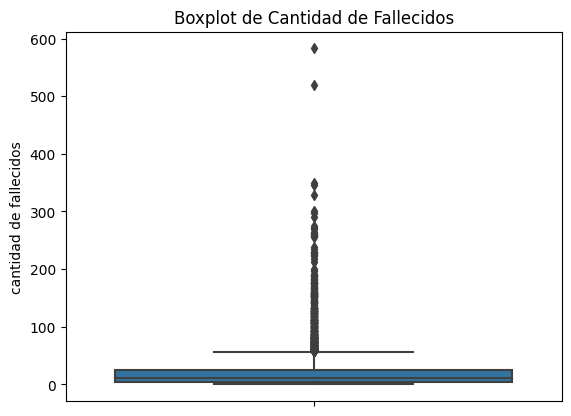

In [22]:
# Cantidad de fallecidos
#Mascaro no nan
mascaraNoNulos = pd.notna(dfAccidentesLimpio['cantidad de fallecidos'])
sns.boxplot(y=dfAccidentesLimpio.loc[mascaraNoNulos, 'cantidad de fallecidos'])
plt.title('Boxplot de Cantidad de Fallecidos')
plt.show()

Conclusión: 
Cuando evaluamos los números de muertos de todos los accidentes aéreos, sin contar con los valores nulos, se puede ver que la mediana y la media tienen valor igual. Asimismo, al hacer esta evaluacion se prueba de que la mayoría de accidentes aéreos tiene un promedio de muertes de 11 personas, y que existen muchos valores atípicos, ya que puede haber accidentes que cuando sucedieron, murieron la totalidad de pasajeros y tripulación abordo 

## 4.3 Cantidad de fallecidos por cada año total

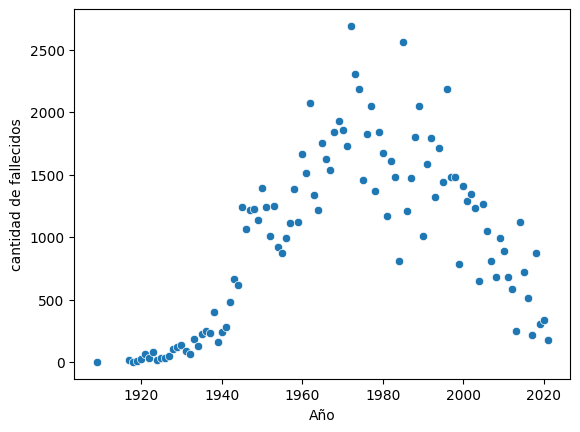

In [23]:
# Sumar por año los fallecidos
total_fallecidos_por_anio = dfAccidentesLimpio.groupby('Año')['cantidad de fallecidos'].sum().reset_index()
sns.scatterplot(x = 'Año',y='cantidad de fallecidos', data = total_fallecidos_por_anio)
plt.show()

Se puede apreciar en el gráfico, que entre los años 1970 y 1990, se suscitaron los accidentes con mayor cantidad de muertos, en este caso se puede asumir que ocurrieron muchos accidentes aéreos o que se produjeron accidentes con una gran cantidad de fallecidos en los años mencionados

## 4.4 Cantidad de Fallecidos por Ruta Pais, los 10 mas altos

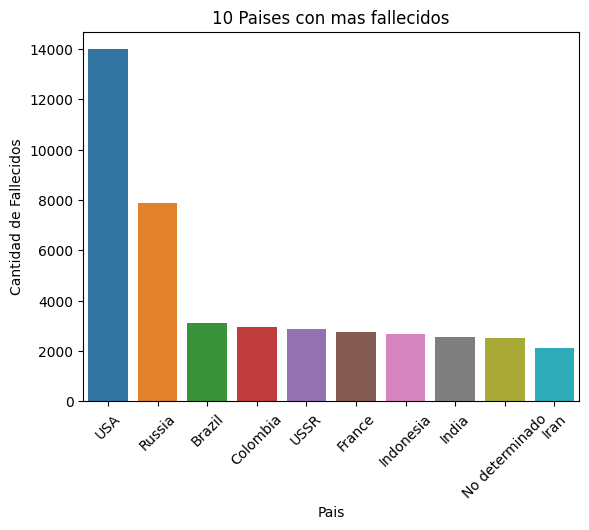

<Figure size 1000x1000 with 0 Axes>

In [24]:
total_fallecidos_porPais = dfAccidentesLimpio.groupby('Pais')['cantidad de fallecidos'].sum().reset_index()
total_fallecidos_porPais = total_fallecidos_porPais.sort_values(by = 'cantidad de fallecidos', ascending =False).reset_index().head(10)

sns.barplot(x='Pais', y='cantidad de fallecidos', data=total_fallecidos_porPais)
# Agregar etiquetas a los ejes y un título al gráfico

plt.xlabel('Pais')
plt.ylabel('Cantidad de Fallecidos')
plt.title('10 Paises con mas fallecidos')
plt.xticks(rotation=45)
plt.figure(figsize=(10,10))
# Mostrar el gráfico

plt.show()

Se ve que los países en donde sucedieron la mayor cantidad de accidentes fue en USA seguido por Rusia y Brasil, esto se debe a que el análisis toma más en cuenta los que sucede en Estados Unidos, por lo que la información puede estar sesgada al no tomar los que pasa en otros países y que puedan influir en el reporte final de los datos

## 4.5 Cantidad de Fallecidos por Tipo Aeronave, los 10 mas altos

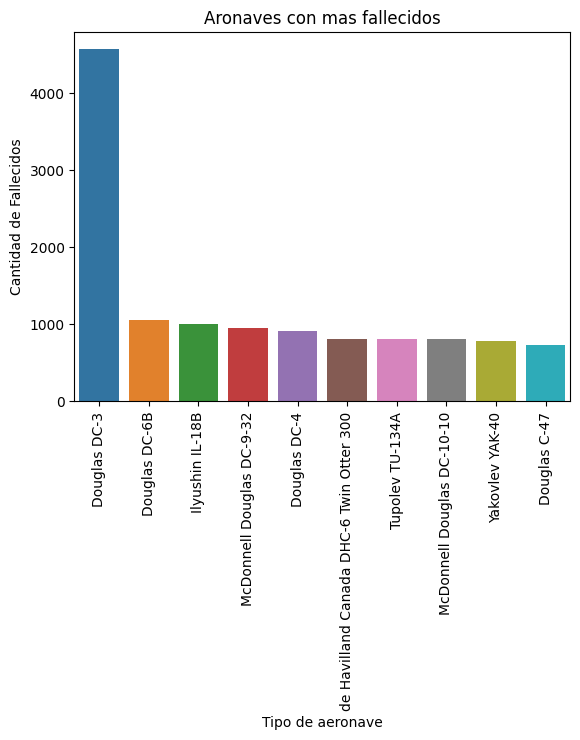

<Figure size 1000x1000 with 0 Axes>

In [25]:
total_fallecidos_aeronave = dfAccidentesLimpio.groupby('Tipo de aeronave')['cantidad de fallecidos'].sum().reset_index()
total_fallecidos_aeronave = total_fallecidos_aeronave.sort_values(by = 'cantidad de fallecidos', ascending =False).reset_index().head(10)

sns.barplot(x='Tipo de aeronave', y='cantidad de fallecidos', data=total_fallecidos_aeronave)
# Agregar etiquetas a los ejes y un título al gráfico

plt.xlabel('Tipo de aeronave')
plt.ylabel('Cantidad de Fallecidos')
plt.title('Aronaves con mas fallecidos')
plt.xticks(rotation=90)
plt.figure(figsize=(10,10))
# Mostrar el gráfico

plt.show()

Se puede ver que los tipos de aeronaves como el Douglas DC-3 es la que más accidentes tuvo, por lo que se debería investigar si los accidentes ocurridos con esta aeronave puedan estar vinculados a desperfectos asociados al tipo de avión o empresa que las fabrica

## 4.6 En tiempo del dia ocurrieron mas accidentes 

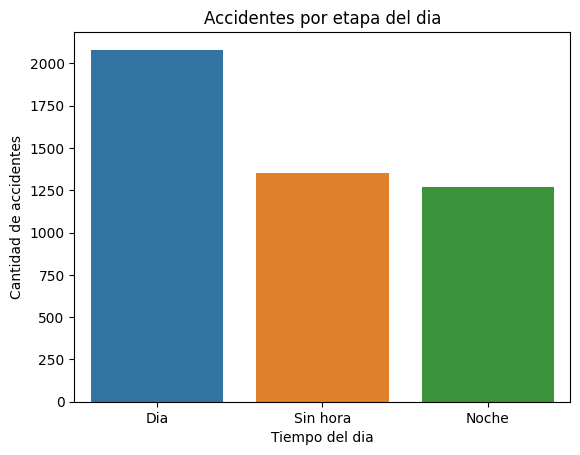

<Figure size 1000x1000 with 0 Axes>

In [26]:
accidentesPorEtapa = dfAccidentesLimpio.groupby('Tiempo')['Operador'].count().reset_index()
accidentesPorEtapa = accidentesPorEtapa.sort_values(by = 'Operador', ascending = False).reset_index()

sns.barplot(x='Tiempo', y='Operador', data=accidentesPorEtapa)
# Agregar etiquetas a los ejes y un título al gráfico
plt.xlabel('Tiempo del dia')
plt.ylabel('Cantidad de accidentes')
plt.title('Accidentes por etapa del dia')
plt.figure(figsize=(10,10))
# Mostrar el gráfico
plt.show()

No muestra de una manera convincente si el tiempo en el que sucedio el accidente fue importante , es decir si fue de día (6am a 6pm) o de noche (6pm a 6am). Asimismo, Se hallo que muchos de los accidentes no tienen una hora declarada

## 4.7 Los 10 operadores aereos con mas accidentes  

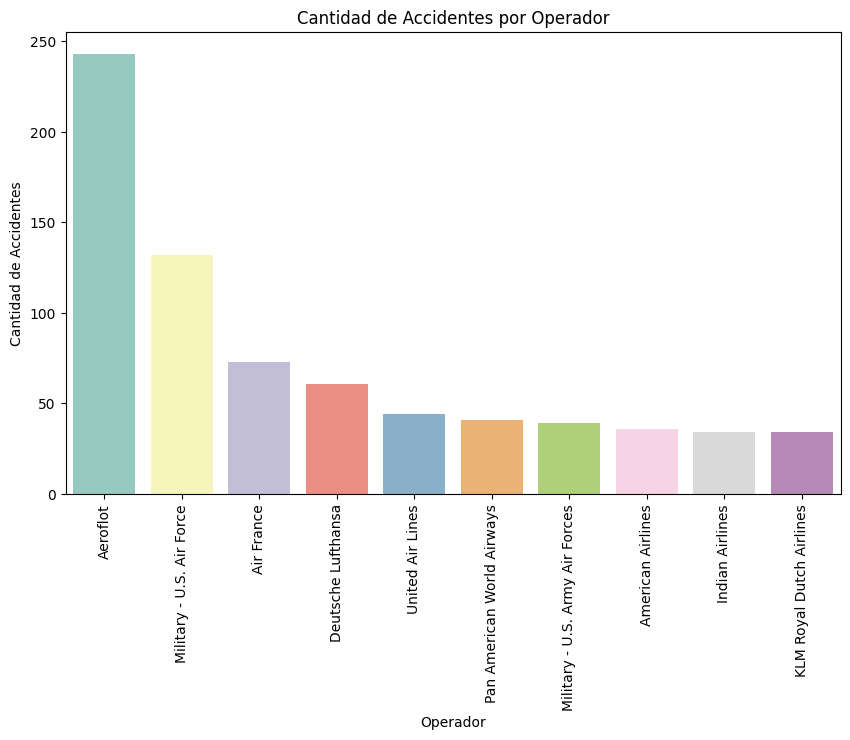

In [27]:
conteo_filas = dfAccidentesLimpio['Operador'].value_counts().reset_index().head(10)
conteo_filas.columns = ['Valor', 'Cantidad']

# Agregar etiquetas a los ejes y un título al gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='Valor', y='Cantidad', data=conteo_filas, palette='Set3')
plt.xlabel('Operador')
plt.ylabel('Cantidad de Accidentes')
plt.title('Cantidad de Accidentes por Operador')
plt.xticks(rotation=90)  # Rotar etiquetas en el eje x para una mejor legibilidad
plt.show()

Se muestran los operadores aéreos a los que se les atribuye la mayor cantidad de accidentes, esta información es de suma importancia, debido a que para futuras investigaciones y/o auditorías a empresas aeronáuticas, se puede llevar procesos de revisión más exhaustivos para las que tuvieron mayor cantidad de accidentes